In [9]:
import pandas as pd

iris_data = pd.read_csv('iris-data.csv', na_values=['NA'])
#iris_data.columns=['sepal_length_cm', 'sepal_width_cm','petal_length_cm','petal_width_cm','class']
iris_data.head() 


,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [10]:
iris_data.describe()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


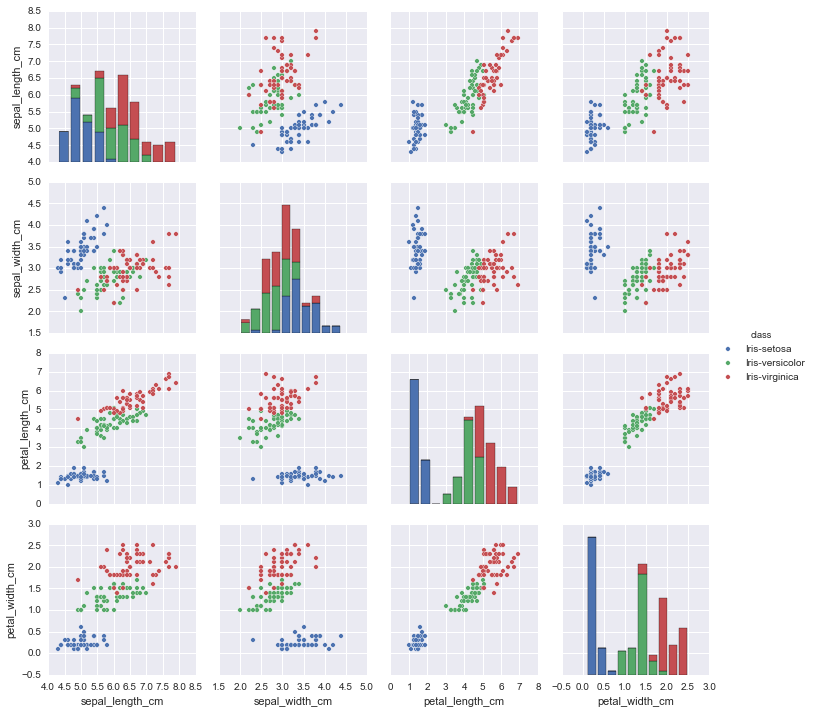

In [14]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
#seaborn for plotting
import seaborn as sb
sb.pairplot(iris_data.dropna(),hue='class')


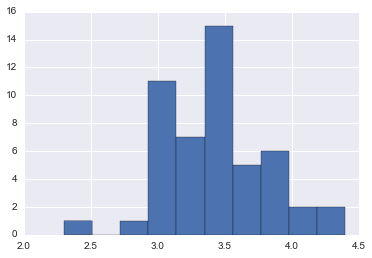

In [15]:
#there's an outlier: one 'sepal_width_cm' entry for Iris-setosa falls well utside its normal range
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'sepal_width_cm'].hist()


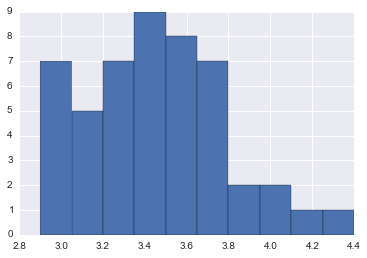

In [17]:
# This line drops any 'Iris-setosa' rows with a separal width less than 2.5 cm
iris_data = iris_data.loc[(iris_data['class'] != 'Iris-setosa') | (iris_data['sepal_width_cm'] >= 2.5)]
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'sepal_width_cm'].hist()

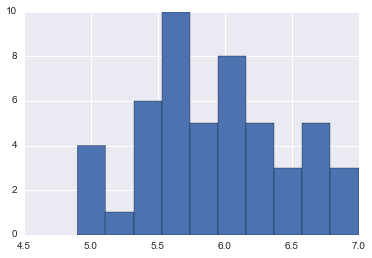

In [18]:
iris_data.loc[iris_data['class'] == 'Iris-versicolor', 'sepal_length_cm'].hist()


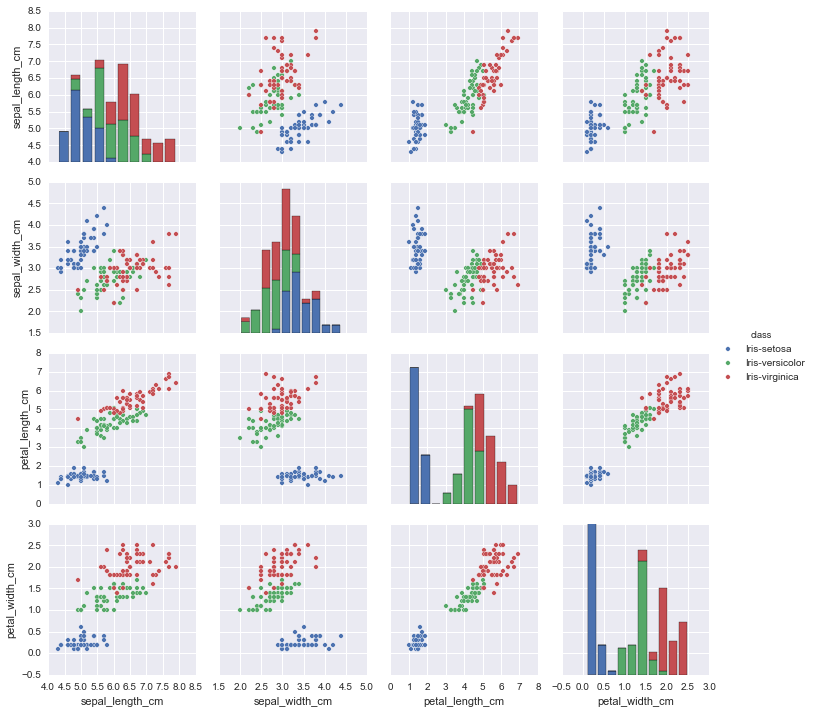

In [22]:
#store to the new csv file
iris_data.to_csv('iris-data-clean.csv', index=False)
iris_data_clean = pd.read_csv('iris-data-clean.csv')
sb.pairplot(iris_data_clean, hue='class')


In [26]:
### Test my data
# We know that we should only have three classes
assert len(iris_data_clean['class'].unique()) == 3
# We know that our data set should have no missing measurements
assert len(iris_data_clean.loc[(iris_data_clean['sepal_length_cm'].isnull()) |
                               (iris_data_clean['sepal_width_cm'].isnull()) |
                               (iris_data_clean['petal_length_cm'].isnull()) |
                               (iris_data_clean['petal_width_cm'].isnull())]) == 0

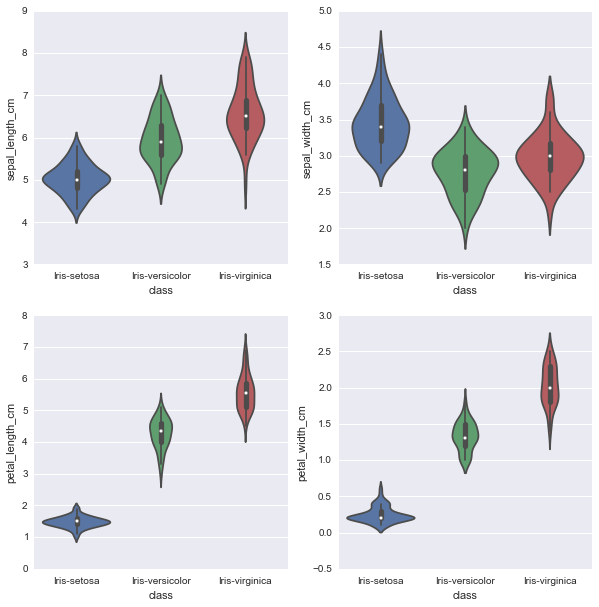

In [29]:
### Exploratory analysis
#The strange distribution of the petal measurements exist because of the different species
#Let's see violin plots of the data to compare the measurement distributions of the classes
plt.figure(figsize=(10, 10))

for column_index, column in enumerate(iris_data_clean.columns):
    if column == 'class':
        continue
    plt.subplot(2, 2, column_index + 1)
    sb.violinplot(x='class', y=column, data=iris_data_clean)

In [40]:
### Classification
#The data is sparse. There is a possibility of overfitting
#Set up the data

# We're using all four measurements as features
# Note that scikit-learn expects each entry to be a list of values, e.g.,
# [ [val1, val2, val3],
#   [val1, val2, val3],
#   ... ]
# such that our input data set is represented as a list of lists
all_features = iris_data_clean[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values

# Similarly, we can extract the classes
all_classes = iris_data_clean['class'].values
all_inputs[:5]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

In [55]:
#Now let's split the data
from sklearn.cross_validation import train_test_split

#75% of total data is training set. 25% is test set.
(training_inputs, testing_inputs, training_classes, 
 testing_classes) = train_test_split(all_features, all_classes, train_size=0.75, random_state=1)

#Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.97368421052631582

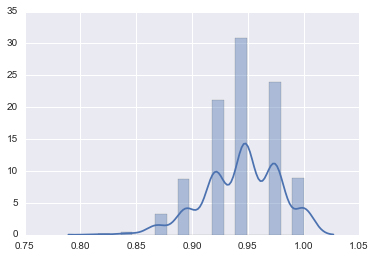

In [56]:
#Depending on how our training and testing set was sampled, our model can achieve anywhere from 80% to 100% accuracy
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_features, all_classes, train_size=0.75)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sb.distplot(model_accuracies)
#sometimes, it's overfitting

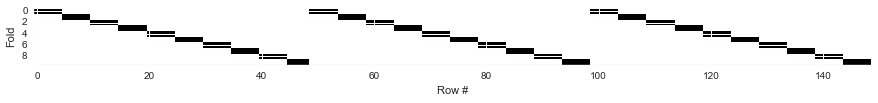

In [58]:
### 10-fold Cross-validation
#stratified
import numpy as np
from sklearn.cross_validation import StratifiedKFold

def plot_cv(cv, n_samples):
    masks = []
    for train, test in cv:
        mask = np.zeros(n_samples, dtype=bool)
        mask[test] = 1
        masks.append(mask)
        
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

#Stratified k-fold keeps the class proportions the same across all of the folds
plot_cv(StratifiedKFold(all_classes, n_folds=10), len(all_classes))

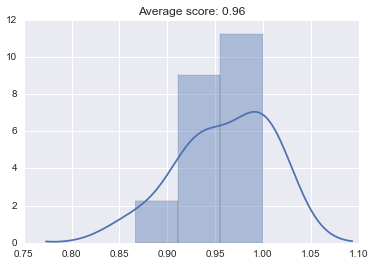

In [59]:
from sklearn.cross_validation import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

#cross_val_score returns a list of the scores, which we can visualize
#to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_features, all_classes, cv=10)
sb.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [60]:
#But what is the best parameter?
### Parameter Tuning
#Grid Search : explore a range of parameters and find the best-performing parameter combination
from sklearn.grid_search import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_features, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.96644295302
Best parameters: {'max_features': 3, 'max_depth': 4}


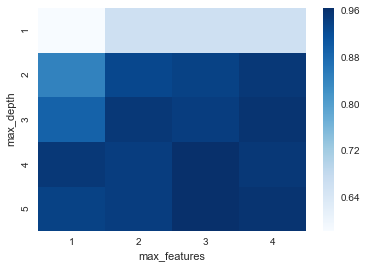

In [61]:
#Visualize
grid_visualization = []

for grid_pair in grid_search.grid_scores_:
    grid_visualization.append(grid_pair.mean_validation_score)
    
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')

In [63]:
#Let's increase score. Let's try Random Forest Algorithm
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [5, 10, 25, 50],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4],
                  'warm_start': [True, False]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_features, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.973154362416
Best parameters: {'max_features': 4, 'n_estimators': 5, 'criterion': 'entropy', 'warm_start': True}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)